In [1]:
import math
import matplotlib.pyplot as plt
from hypergrammar.hypergraph import Hypergraph
from hypergrammar.edge import Edge, EdgeType
from hypergrammar.productions.prod_7 import Prod7

# Setup Enums and Monkeypatching
if not hasattr(EdgeType, 'P'):
    try:
        import aenum
        aenum.extend_enum(EdgeType, 'P', 99)
    except ImportError: pass

def edge_str_with_params(self):
    # Custom label: Shows R parameter clearly
    r_val = self.parameters.get("R")
    label = self.edge_type.name
    if r_val is not None:
        label += f"\nR={r_val}"
    return label
Edge.__str__ = edge_str_with_params

# Function to create a Pentagon Hypergraph 
def create_pentagon_hg(p_r_val=1, break_topology=False):
    hg = Hypergraph()
    verts = ["v1", "v2", "v3", "v4", "v5"]
    
    # 1. Geometry (Coordinates)
    center = (2.5, 2.5); radius = 2.0
    for i, v in enumerate(verts):
        angle_rad = math.radians(90 + i * 72)
        hg.set_vertex_parameter(v, {
            "x": center[0] + radius * math.cos(angle_rad),
            "y": center[1] + radius * math.sin(angle_rad)
        })

    # 2. Boundary Edges (Type E)
    # If break_topology is True, we skip the last edge to break the cycle
    pairs = [("v1", "v2"), ("v2", "v3"), ("v3", "v4"), ("v4", "v5"), ("v5", "v1")]
    if break_topology:
        pairs.pop() # Remove v5-v1
        
    for v1, v2 in pairs:
        hg.add_edge(Edge(EdgeType.E, frozenset({v1, v2}), {"R": 0, "B": 1}))

    # 3. Central Edge (Type P)
    hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": p_r_val}))
    
    return hg



TEST 1: Valid Application
Production applied successfully.


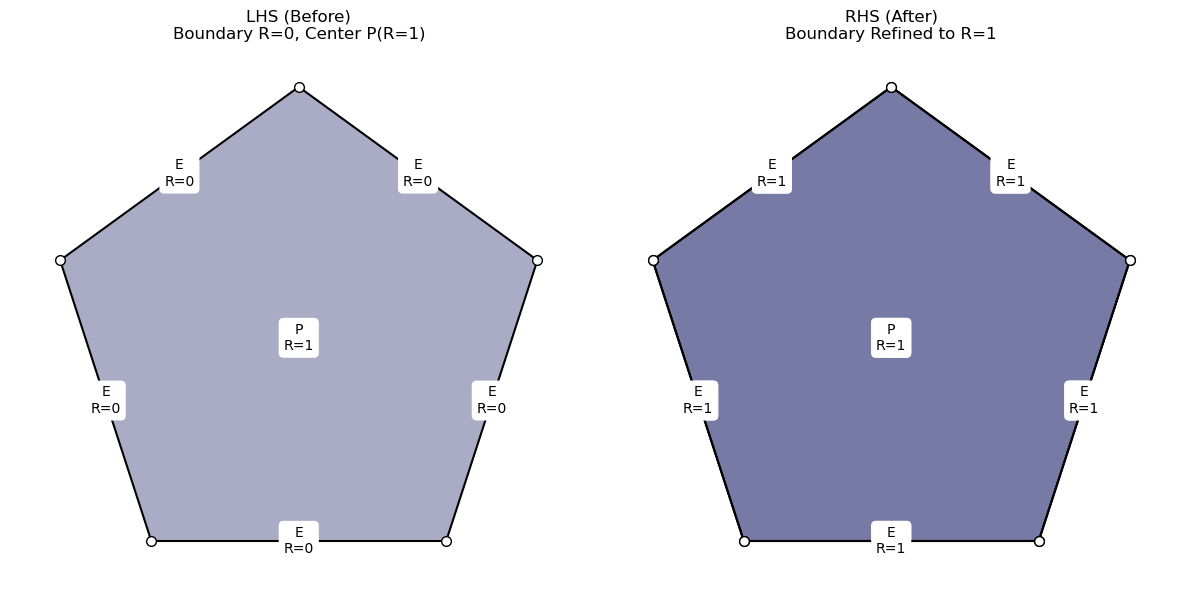

In [2]:
print("\nTEST 1: Valid Application")
hg_valid = create_pentagon_hg(p_r_val=1) # Correct R=1

# Apply Production
prod7 = Prod7()
result_valid = prod7.apply(hg_valid)

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title("LHS (Before)\nBoundary R=0, Center P(R=1)")
hg_valid.draw(use_positional_parameters=True) 

plt.sca(axes[0]) # Set current axis to left
hg_valid.draw(use_positional_parameters=True)

if result_valid:
    plt.sca(axes[1]) # Set current axis to right
    axes[1].set_title("RHS (After)\nBoundary Refined to R=1")
    result_valid.draw(use_positional_parameters=True)
    print("Production applied successfully.")
else:
    print("Production failed unexpectedy.")
    
plt.tight_layout()
plt.show()


TEST 2: Complex Hypergraph
Production applied successfully on complex HG.


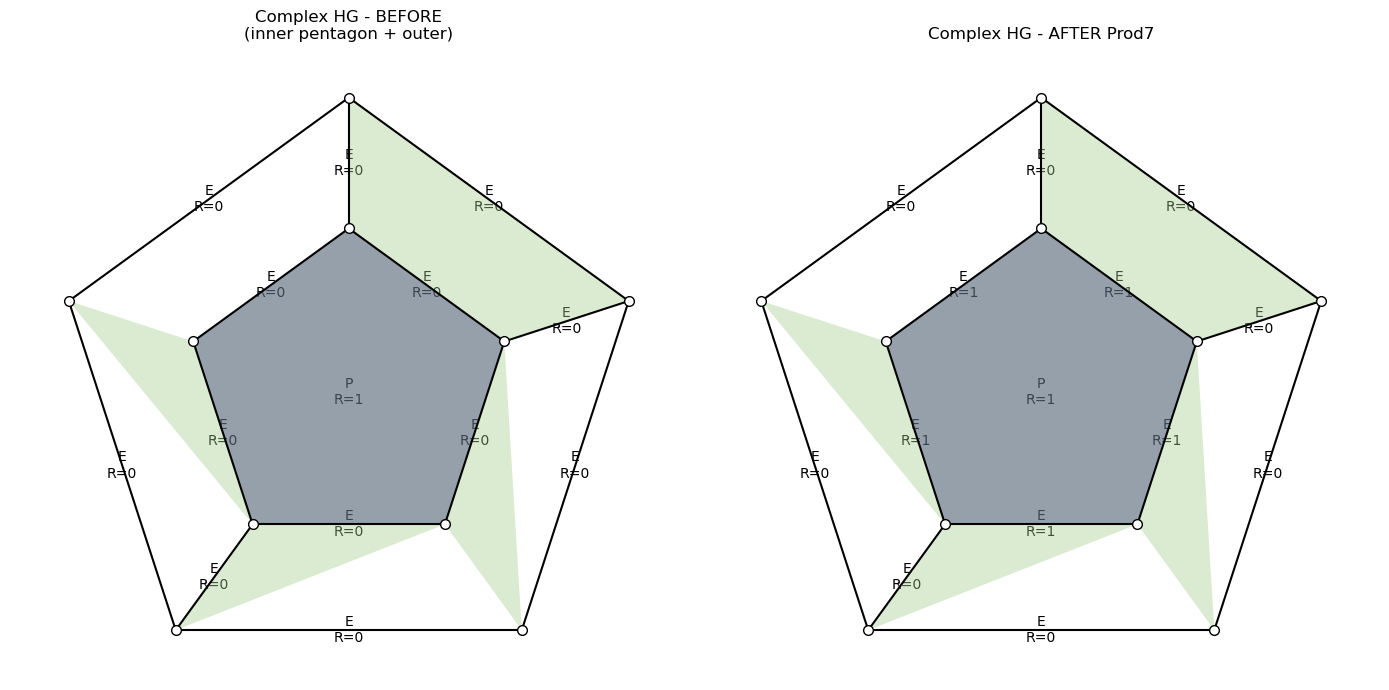

In [3]:
# Function to create a complex hypergraph containing the pentagon inside
def create_complex_hg():
    hg = Hypergraph()

    inner_hg = create_pentagon_hg(p_r_val=1, break_topology=False)

    # Copy vertex parameters
    for v in inner_hg._node_parameters.keys():
        hg.set_vertex_parameter(v, inner_hg.get_vertex_parameters(v))

    # Copy edges
    for e in inner_hg.get_edges():
        hg.add_edge(e)

    outer_vertices = ["o1", "o2", "o3", "o4", "o5"]
    center = (2.5, 2.5)
    outer_radius = 3.6

    for i, v in enumerate(outer_vertices):
        angle_rad = math.radians(90 + i * 72)
        hg.set_vertex_parameter(v, {
            "x": center[0] + outer_radius * math.cos(angle_rad),
            "y": center[1] + outer_radius * math.sin(angle_rad),
        })

    outer_pairs = [
        ("o1", "o2"), ("o2", "o3"), ("o3", "o4"),
        ("o4", "o5"), ("o5", "o1")
    ]

    for v1, v2 in outer_pairs:
        hg.add_edge(Edge(EdgeType.E, frozenset({v1, v2}), {"R": 0, "B": 1}))

    cross_pairs = [
        ("v1", "o1"),
        ("v3", "o3"),
        ("v5", "o5")
    ]

    for v1, v2 in cross_pairs:
        hg.add_edge(Edge(EdgeType.E, frozenset({v1, v2}), {"R": 0, "B": 1}))

    all_vertices = set(inner_hg._node_parameters.keys()) | set(outer_vertices)

    hg.add_edge(Edge(
        EdgeType.P,
        frozenset(all_vertices),
        {"R": 1}
    ))

    return hg


print("\nTEST 2: Complex Hypergraph")
hg_complex = create_complex_hg()

prod7 = Prod7()
result_complex = prod7.apply(hg_complex)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].set_title("Complex HG - BEFORE\n(inner pentagon + outer)")
plt.sca(axes[0])
hg_complex.draw(use_positional_parameters=True)

if result_complex:
    axes[1].set_title("Complex HG - AFTER Prod7")
    plt.sca(axes[1])
    result_complex.draw(use_positional_parameters=True)
    print("Production applied successfully on complex HG.")
else:
    print("Production failed on complex HG.")

plt.tight_layout()
plt.show()



 TEST 2: Negative Case (Wrong R Value)
Correctly rejected graph with R=0.


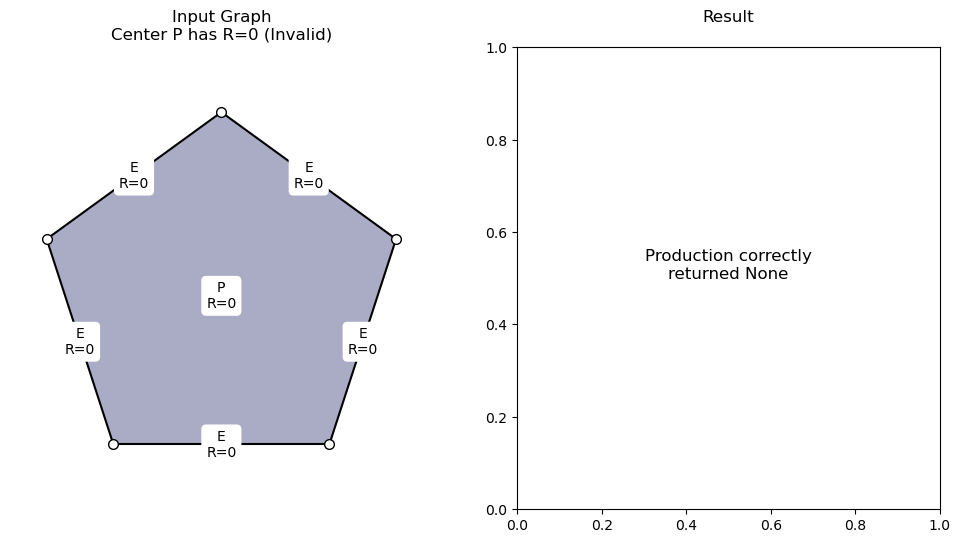

In [4]:
print("\n TEST 2: Negative Case (Wrong R Value)")
hg_wrong_r = create_pentagon_hg(p_r_val=0) # Incorrect R=0

result_wrong_r = prod7.apply(hg_wrong_r)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
axes[0].set_title("Input Graph\nCenter P has R=0 (Invalid)")
hg_wrong_r.draw(use_positional_parameters=True)

plt.sca(axes[1])
axes[1].set_title("Result\n")
if result_wrong_r is None:
    axes[1].text(0.5, 0.5, "Production correctly\nreturned None", ha='center', fontsize=12)
    print("Correctly rejected graph with R=0.")
else:
    result_wrong_r.draw(use_positional_parameters=True)
    print("Error: Production applied when it should not have.")
    
plt.show()


TEST 3: Negative Case (Broken Cycle)
Correctly rejected graph with broken cycle.


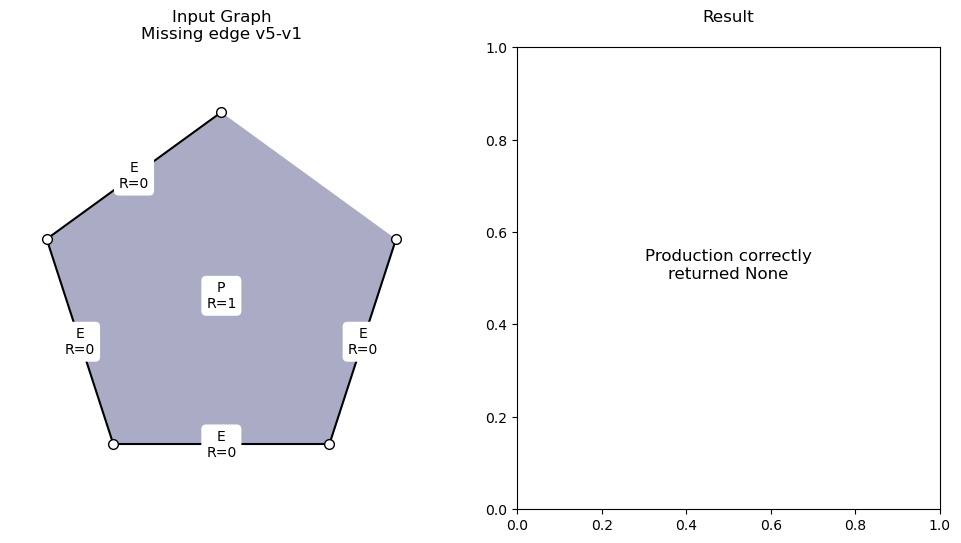

In [5]:
print("\nTEST 3: Negative Case (Broken Cycle)")
hg_broken = create_pentagon_hg(p_r_val=1, break_topology=True) # Missing one edge

result_broken = prod7.apply(hg_broken)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
axes[0].set_title("Input Graph\nMissing edge v5-v1")
hg_broken.draw(use_positional_parameters=True)

plt.sca(axes[1])
axes[1].set_title("Result\n")
if result_broken is None:
    axes[1].text(0.5, 0.5, "Production correctly\nreturned None", ha='center', fontsize=12)
    print("Correctly rejected graph with broken cycle.")
else:
    result_broken.draw(use_positional_parameters=True)
    print("Error: Production applied to broken topology.")

plt.show()

In [6]:
import unittest
# Assuming your modules are in the python path. If not, you may need:
# import sys; sys.path.append('path/to/your/project')
from hypergrammar.hypergraph import Hypergraph
from hypergrammar.edge import Edge, EdgeType
from hypergrammar.productions.prod_7 import Prod7

# --- Helper: Mock EdgeType.P if needed ---
if not hasattr(EdgeType, 'P'):
    try:
        import aenum
        aenum.extend_enum(EdgeType, 'P', 99)
    except ImportError:
        pass 

# --- Test Class Adapted for Jupyter ---
class TestProd7(unittest.TestCase):
    """Test suite for Production 7 running in Jupyter."""

    def test_apply_valid_p7(self):
        """Test that P7 applies correctly to a valid pentagon with R=1."""
        hg = Hypergraph()
        verts = ["v1", "v2", "v3", "v4", "v5"]
        
        # 1. Create boundary E edges (Pentagon cycle)
        edges_data = [
            (("v1", "v2"), 10), (("v2", "v3"), 20),
            (("v3", "v4"), 30), (("v4", "v5"), 40), (("v5", "v1"), 50)
        ]
        for pair, b_val in edges_data:
            hg.add_edge(Edge(EdgeType.E, frozenset(pair), {"R": 0, "B": b_val}))

        # 2. Create the central P edge with R=1
        hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": 1}))

        prod7 = Prod7()
        result = prod7.apply(hg)

        # Assertions
        self.assertIsNotNone(result, "Production should return a hypergraph, not None")
        
        edges = result.get_edges()
        
        # Check P edge still exists with R=1
        p_edges = [e for e in edges if e.get_type() == EdgeType.P]
        self.assertEqual(len(p_edges), 1, "Should have exactly one P edge")
        self.assertEqual(p_edges[0].get_parameters()["R"], 1, "P edge R parameter should remain 1")
        
        # Check E edges
        e_edges = [e for e in edges if e.get_type() == EdgeType.E]
        self.assertEqual(len(e_edges), 5, "Should have 5 boundary E edges")
        
        # Verify ALL E edges now have R=1
        for edge in e_edges:
            self.assertEqual(edge.get_parameters()["R"], 1, f"Edge {edge.get_vertices()} R parameter should be 1")
            
        # Verify specific B value preservation (example: v1-v2 had B=10)
        e_v1_v2 = next(e for e in e_edges if e.get_vertices() == frozenset({"v1", "v2"}))
        self.assertEqual(e_v1_v2.get_parameters()["B"], 10, "Parameter B should be preserved")

    def test_apply_fails_if_p_has_wrong_r(self):
        """Test that P7 does NOT apply if P edge has R != 1."""
        hg = Hypergraph()
        verts = ["v1", "v2", "v3", "v4", "v5"]
        
        # Add valid cycle
        pairs = [("v1", "v2"), ("v2", "v3"), ("v3", "v4"), ("v4", "v5"), ("v5", "v1")]
        for pair in pairs:
            hg.add_edge(Edge(EdgeType.E, frozenset(pair)))

        # Add P edge with R=0 (Invalid trigger)
        hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": 0}))

        prod7 = Prod7()
        result = prod7.apply(hg)
        self.assertIsNone(result, "Production should not apply if R=0")

    def test_apply_fails_broken_topology(self):
        """Test that P7 does NOT apply if the E-edges do not form a closed pentagon."""
        hg = Hypergraph()
        verts = ["v1", "v2", "v3", "v4", "v5"]
        
        # Broken cycle (missing v5-v1)
        pairs = [("v1", "v2"), ("v2", "v3"), ("v3", "v4"), ("v4", "v5")]
        for pair in pairs:
            hg.add_edge(Edge(EdgeType.E, frozenset(pair)))

        hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": 1}))

        prod7 = Prod7()
        result = prod7.apply(hg)
        self.assertIsNone(result, "Production should not apply to broken topology")

    def test_apply_fails_wrong_vertex_count(self):
        """Test that P7 does not apply to a square (4 vertices) even if labeled P."""
        hg = Hypergraph()
        verts = ["v1", "v2", "v3", "v4"]
        
        # Square cycle
        pairs = [("v1", "v2"), ("v2", "v3"), ("v3", "v4"), ("v4", "v1")]
        for pair in pairs:
            hg.add_edge(Edge(EdgeType.E, frozenset(pair)))

        hg.add_edge(Edge(EdgeType.P, frozenset(verts), {"R": 1}))

        prod7 = Prod7()
        result = prod7.apply(hg)
        self.assertIsNone(result, "Production should not apply to a square")

# --- Run the tests ---
# argv=['first-arg-is-ignored'] ignores Jupyter command line args
# exit=False prevents the kernel from stopping
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.001s

OK
